In [ ]:
# Moroccan Date Fruit Classification using Transfer Learning and Color-Texture Attention

#This notebook demonstrates the use of fine-tuned VGG19 combined with handcrafted preprocessing (HSV + Gabor) to classify Moroccan date fruit varieties under semi-controlled environments.


In [1]:
# Optional: Mount Google Drive if running in Google Colab
# from google.colab import drive
# drive.mount('/content/gdrive')

# Set the path to the dataset
# If running locally, set your own path like:
data_path = "data/dates"  # <-- default local path
# data_path = "/content/gdrive/MyDrive/Colab Notebooks/dates"  # <-- use if on Colab


Mounted at /content/gdrive


In [3]:
import os
import cv2
import numpy as np

SIZE = 224  # Resize target

def get_avg_gabor(gray_img):
    """Apply Gabor filters at multiple orientations and average the responses."""
    gabor_sum = np.zeros(gray_img.shape, dtype=np.float32)
    for theta in [0, np.pi/4, np.pi/2, 3*np.pi/4]:
        kernel = cv2.getGaborKernel((21, 21), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        gabor_filtered = cv2.filter2D(gray_img, cv2.CV_32F, kernel)
        gabor_sum += gabor_filtered
    gabor_avg = gabor_sum / 4
    return np.uint8(gabor_avg)

def preprocess_gabor_hsv(img_path):
    """
    Load an image, convert it to HSV, apply Gabor filtering,
    and return a 3-channel input [Hue, Saturation, Gabor] normalized to [0, 1].
    """
    img = cv2.imread(img_path)
    img = cv2.resize(img, (SIZE, SIZE))

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hue = hsv[:, :, 0]
    sat = hsv[:, :, 1]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gabor = get_avg_gabor(gray)

    combined = np.stack([hue, sat, gabor], axis=-1)
    combined = combined / 255.0

    return combined

def load_dataset(data_path):
    """
    Load and preprocess all images in a folder-structured dataset.
    Each subfolder in `data_path` should be named after a class.
    """
    images = []
    labels = []

    for label, class_name in enumerate(sorted(os.listdir(data_path))):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
        print(f"Processing class: {class_name}, Label: {label}")

        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = preprocess_gabor_hsv(img_path)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing image {img_name}: {str(e)}")

    return np.array(images), np.array(labels)



Processing class: Al majhoul, Label: 0
Processing class: Askri, Label: 1
Processing class: Boufgous, Label: 2
Processing class: Aziza, Label: 3
Processing class: BouFgous2, Label: 4
Processing class: Jihl, Label: 5
Processing class: Soukari, Label: 6
Processing class: Tathmot, Label: 7
Processing class: Bouzkri, Label: 8
Shape of train_images: (897, 224, 224, 3)
Shape of train_labels: (897,)


now after loading the images , training the model.

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Resize constant
SIZE = 224

#  Custom head builder
def build_model(feature_extractor, num_classes=9, dense_units=64, dropout_rate=0.3):
    """
    Attach a classification head on top of a base CNN.
    """
    x = feature_extractor.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

    return Model(inputs=feature_extractor.input, outputs=output)

#  Label encoding
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)

#  Train/val/test split (70/15/15)
x_train, x_temp, y_train, y_temp = train_test_split(train_images, train_labels_encoded, test_size=0.3, random_state=66)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=66)

#  One-hot encode
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)













In [6]:

# Features Extractor defining
feature_extractor = VGG19(weights="imagenet", include_top=False)
# Tackle Block 4 of VGG19
feature_extractor = tf.keras.models.Sequential(feature_extractor.layers[:-5])
# Freez 13 first layers and make 3 last ones updates during training
for layer in feature_extractor.layers[:13]:
    layer.trainable = False
for layer in feature_extractor.layers[13:]:
    layer.trainable = True

feature_extractor.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,585,152 (40.38 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 5,865,536 (22.38 MB)

In [10]:
#puting everything together
dummy_input = tf.keras.Input(shape=(224, 224, 3))
_ = feature_extractor(dummy_input)

headModel = build_model(feature_extractor, 9, 32)

model = Model(feature_extractor.input, outputs=headModel)

## defin optimizer with low learning rate
Optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4)

model.compile(optimizer=Optimizer ,loss = 'categorical_crossentropy', metrics = ['accuracy'] )

print(model.summary())

##########################################
#Train the CNN model

history = model.fit( x_train, y_train_one_hot, batch_size=32, epochs=60, validation_data=(x_val, y_val_one_hot))




Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 14, 14, 512)    │    10,585,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,601,865 (40.44 MB)

 Trainable params: 4,736,329 (18.07 MB)

 Non-trainable params: 5,865,536 (22.38 MB)

None
Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 471ms/step - accuracy: 0.2146 - loss: 4.4063 - val_accuracy: 0.5333 - val_loss: 1.4811
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step - accuracy: 0.5218 - loss: 1.3834 - val_accuracy: 0.5630 - val_loss: 1.1969
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.5830 - loss: 1.1365 - val_accuracy: 0.6963 - val_loss: 1.1504
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step - accuracy: 0.7237 - loss: 0.8048 - val_accuracy: 0.6593 - val_loss: 0.9878
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - accuracy: 0.6985 - loss: 0.8683 - val_accuracy: 0.7037 - val_loss: 0.9463
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step - accuracy: 0.7503 - loss: 0.6796 - val_accuracy: 0.8296 - val_loss: 0.5977
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - accuracy: 0.7764 - loss: 0.6731 - val_accuracy: 0.8296 - val_loss: 0.6102
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.7747 - loss: 0.6568 - val_

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9376 - loss: 0.1844
Test Accuracy: 94.81%


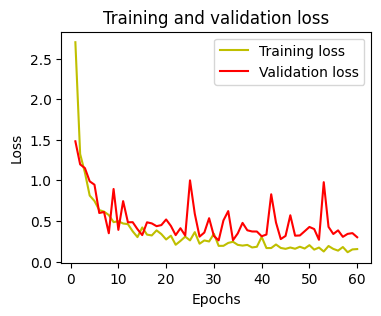

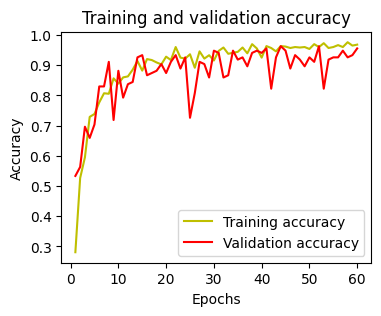

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
from google.colab.patches import cv2_imshow
from PIL import Image
# Evaluate the model on the test set
_, test_accuracy = model.evaluate(x_test, y_test_one_hot)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


#plot the training and validation accuracy and loss at each epoch
plt.figure(figsize=(4, 3))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(4, 3))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:

# Save the model
model_save_path = "path/model.h5"

# Save full model (architecture + weights)
model.save(model_save_path)

print(f"✅ Model saved to: {model_save_path}")

✅ Model saved to: /content/gdrive/MyDrive/Colab Notebooks/models/date22.h5
